# Imports, data loading, and functions #

In [53]:
import os
import pandas as pd
import sqlite3
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from wordcloud import WordCloud
import random
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import spacy
nlp = spacy.load('en_core_web_sm')
from spacy import displacy
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

## Import custom functions from 'regression_functions.py' ##
try:
    import importlib
    importlib.reload(fn)
except NameError: # It hasn't been imported yet
    import supervised_learning_functions as fn

## Import custom functions from 'regression_functions.py' ##
try:
    import importlib
    importlib.reload(mh)
except NameError: # It hasn't been imported yet
    import mh_functions as mh
    
data_directory = 'C:/Users/61407/mental-health-modelling/data'
db = 'mental_health.sqlite'

con = sqlite3.connect(os.path.join(data_directory, db))
cur = con.cursor()

sns.set()

## 3. Feature selection ##

- only select questions/features where there are at least 500 non-null values

In [100]:
structured_df = pd.read_pickle('structured_data_undiagnosed.plk')
null_filtered = structured_df.iloc[:,np.where((structured_df.count() > 500))[0]]

In [29]:
filtered_features = tuple(list(null_filtered.columns))
for idx, q in pd.read_sql_query(f'SELECT questionid, questiontext FROM Question WHERE questionid IN {filtered_features}', con).iterrows():
    print(f'{q.questionid}. {q.questiontext}')

1. What is your age?
2. What is your gender?
3. What country do you live in?
4. If you live in the United States, which state or territory do you live in?
5. Are you self-employed?
6. Do you have a family history of mental illness?
7. Have you ever sought treatment for a mental health disorder from a mental health professional?
8. How many employees does your company or organization have?
9. Is your employer primarily a tech company/organization?
10. Does your employer provide mental health benefits as part of healthcare coverage?
11. Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?
12. Would you bring up a mental health issue with a potential employer in an interview?
13. Is your primary role within your company related to tech/IT?
14. Do you know the options for mental health care available under your employer-provided health coverage?
15. Has your employer ever formally discussed mental hea

- Remove questions where there are responses that occur < 10 times
- we should keep age since that is an ordinal feature

In [45]:
print('Questions with less than 10 occurrences for a given response to a question:')

questions_to_keep = []
## Check the responses to each question ##
for col_name, col_data in null_filtered.items():
    q = pd.read_sql_query(f'SELECT questionid, questiontext FROM Question WHERE questionid = {col_name}', con)
    min_response = col_data.value_counts().min()
    
    if (min_response < 10) & ('age' not in q.questiontext[0]):
        print(f'{q.questionid[0]}. {q.questiontext[0]}')
    else:
        questions_to_keep.append(q.questionid[0])

Questions with less than 10 occurrences for a given response to a question:
2. What is your gender?
3. What country do you live in?
4. If you live in the United States, which state or territory do you live in?
50. What country do you work in?
51. What US state or territory do you work in?
77. Overall, how much importance did your previous employer place on mental health?
83. Have you observed or experienced supportive or well handled response to a mental health issue in your current or previous workplace?
86. Briefly describe what you think the industry as a whole and/or employers could do to improve mental health support for employees.
113. Do you feel that being identified as a person with a mental health issue would hurt your career?
117. Which of the following best describes your work position?


- visualize responses to filtered questions

C:\Users\61407\AppData\Local\Temp\ipykernel_24788\12344999.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(15,1.5))


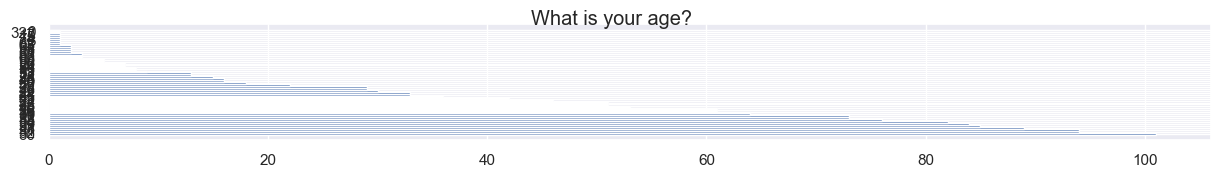

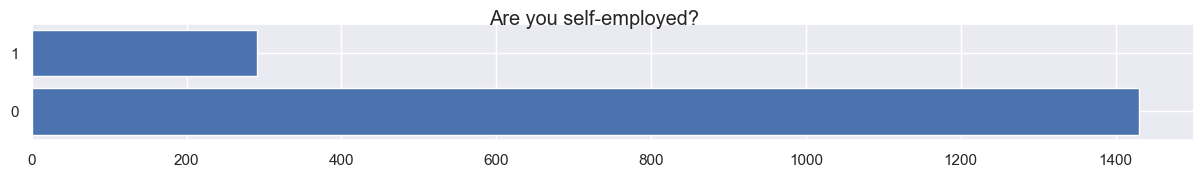

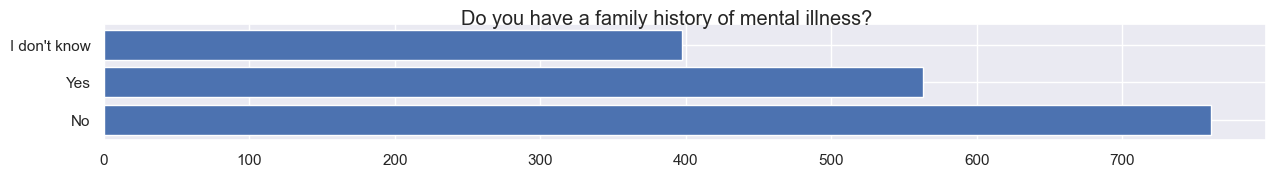

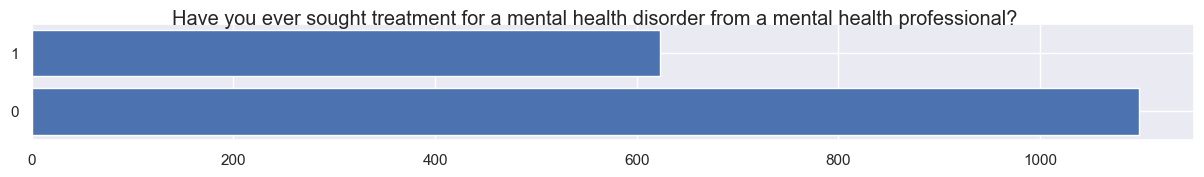

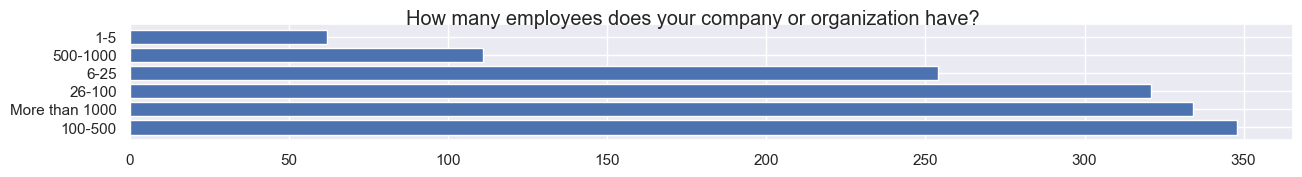

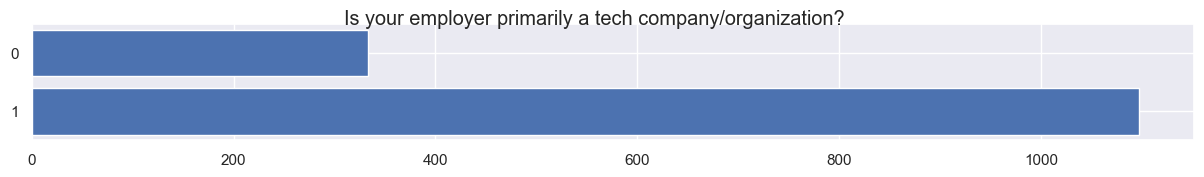

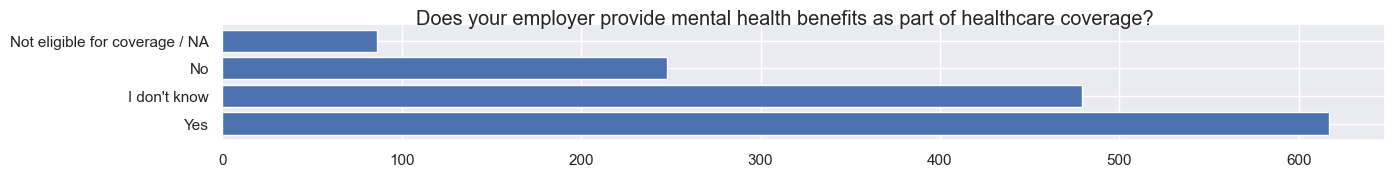

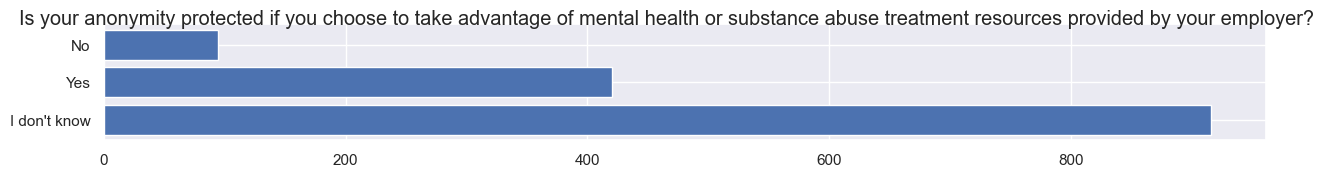

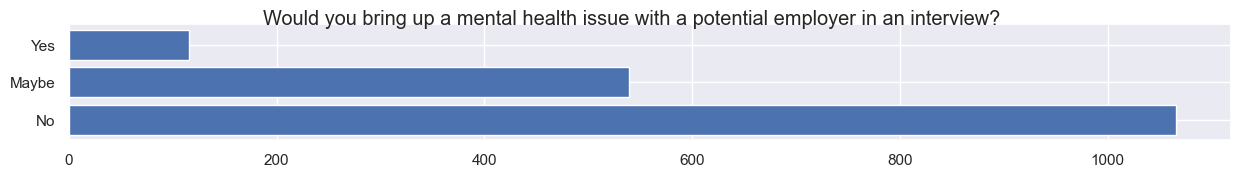

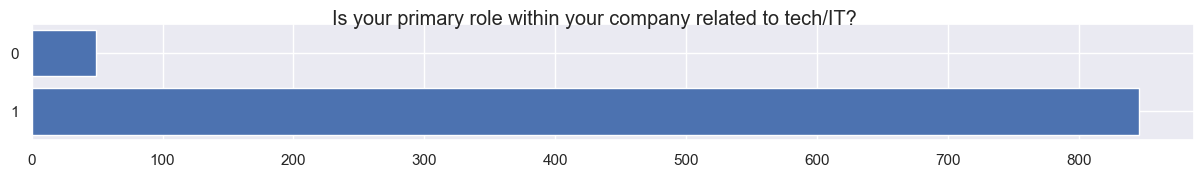

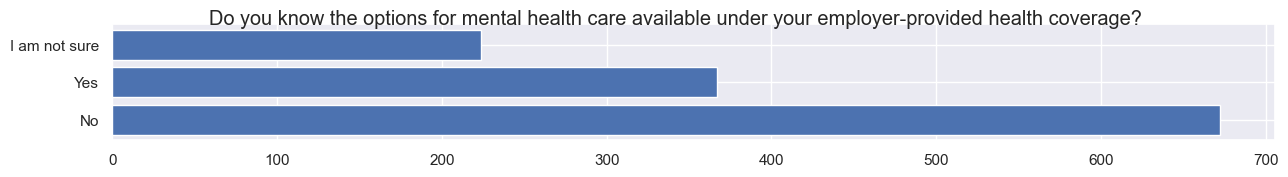

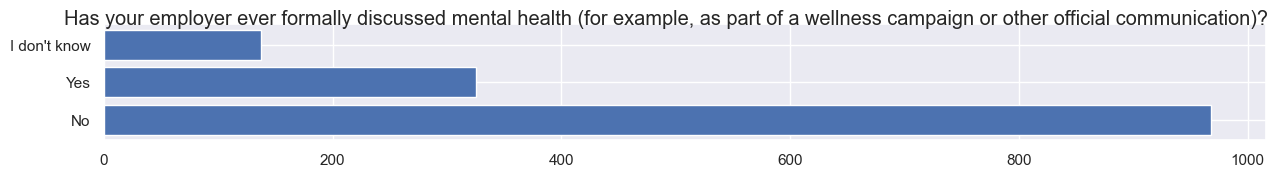

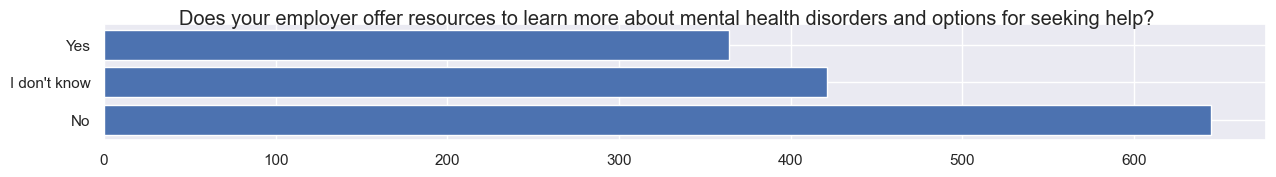

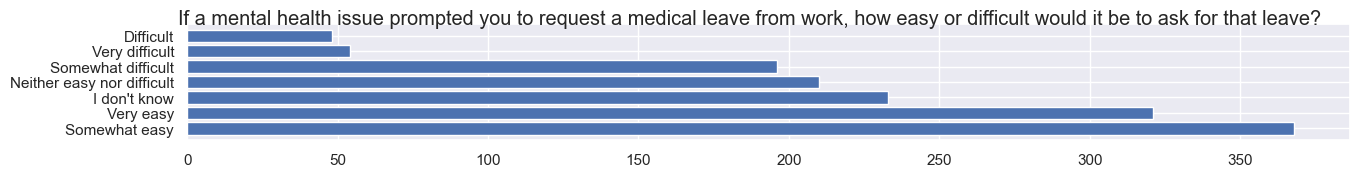

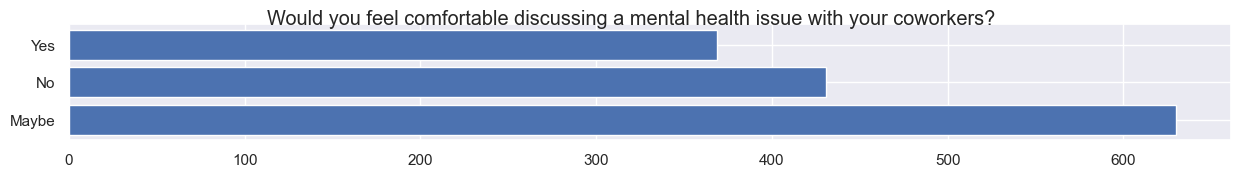

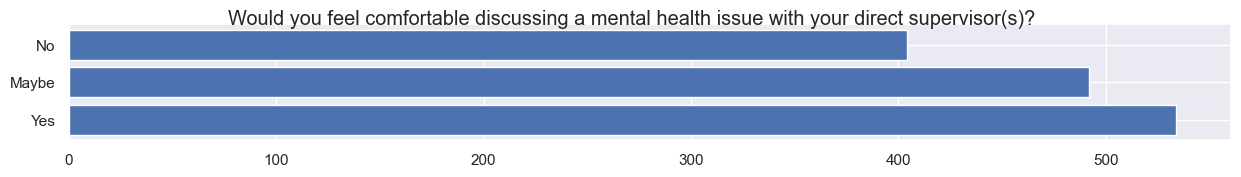

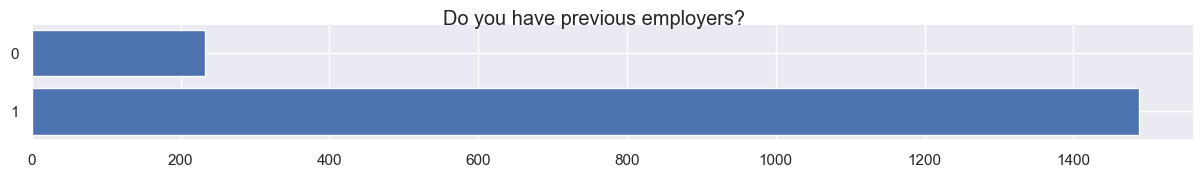

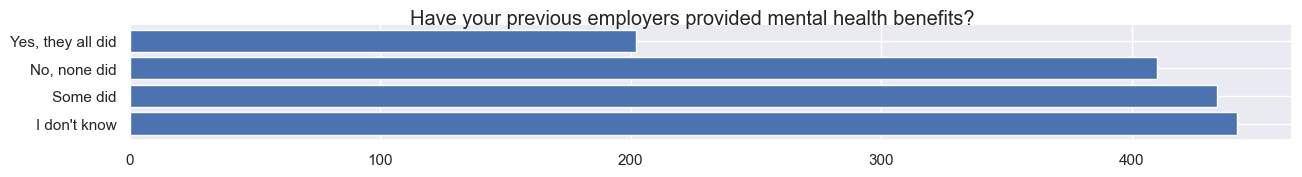

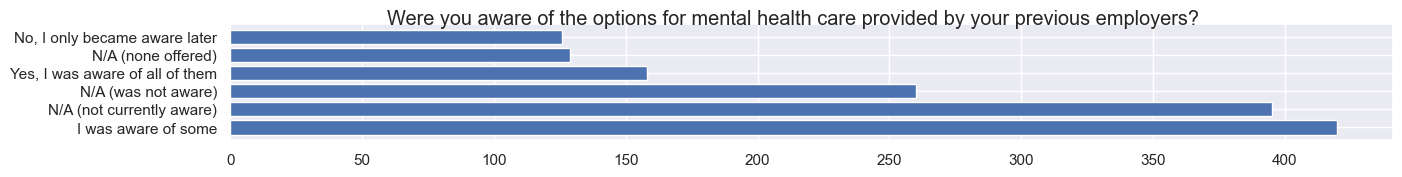

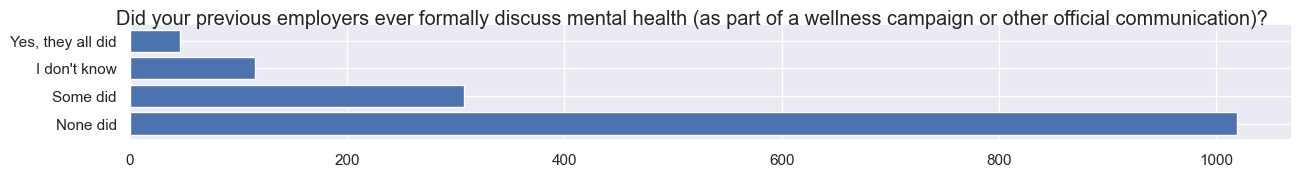

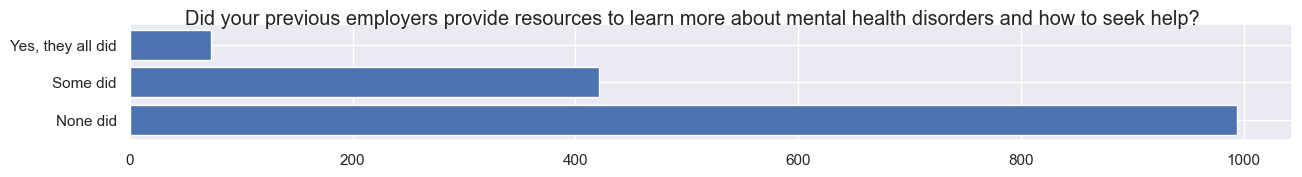

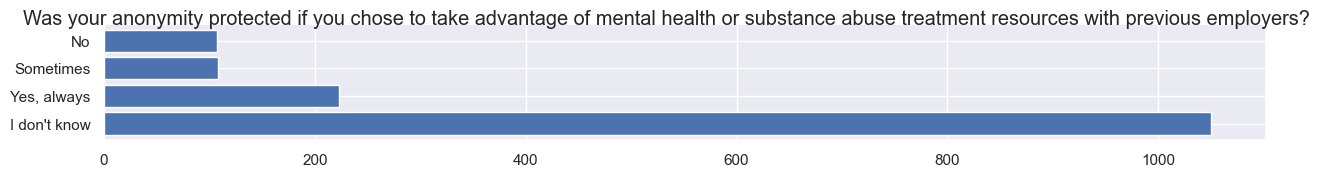

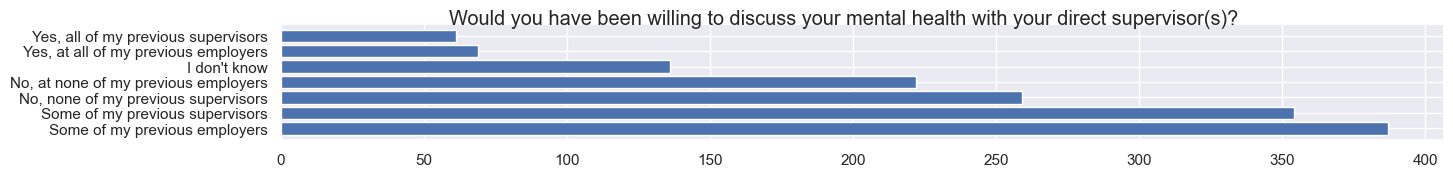

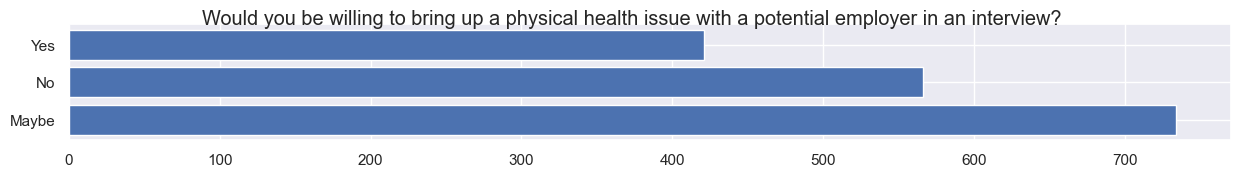

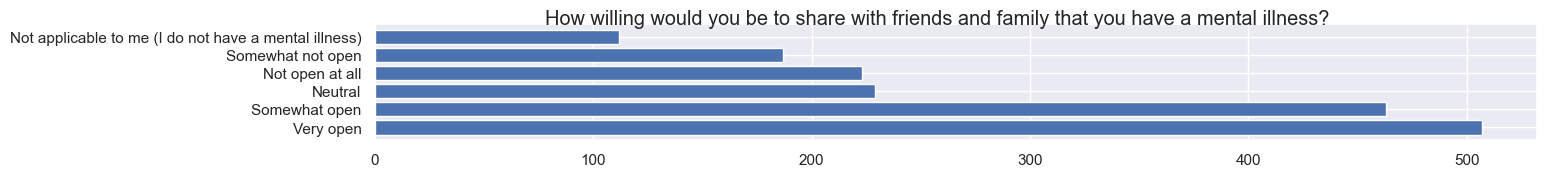

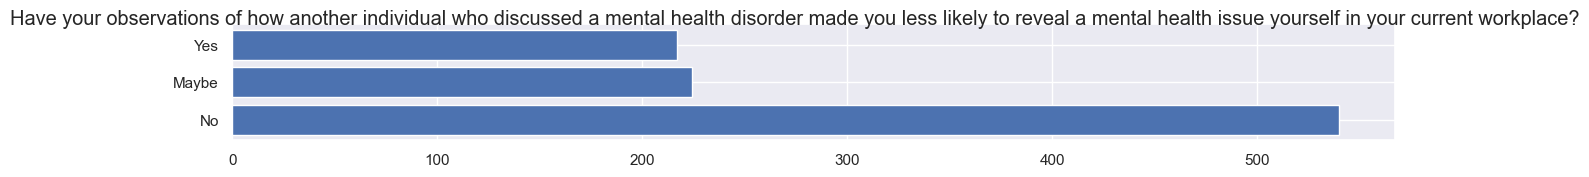

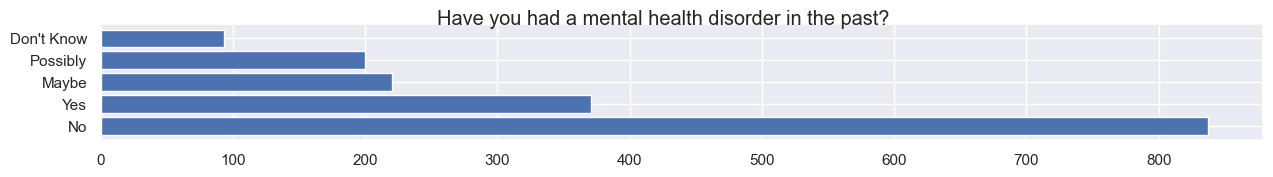

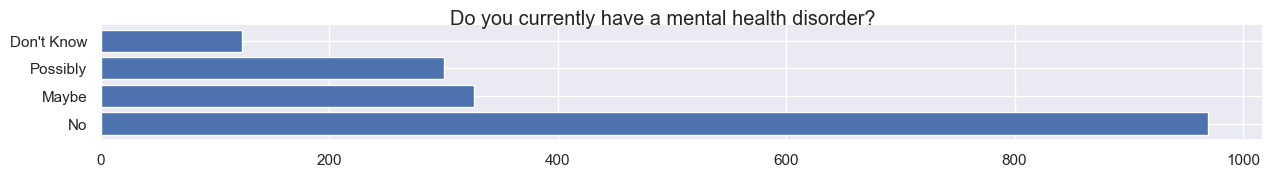

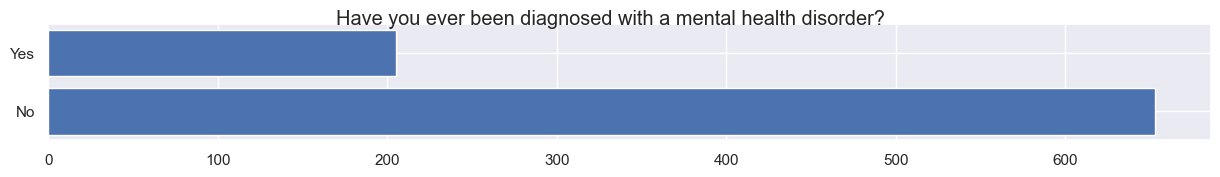

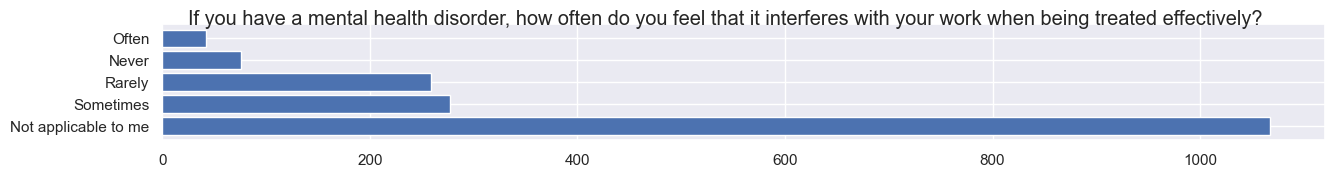

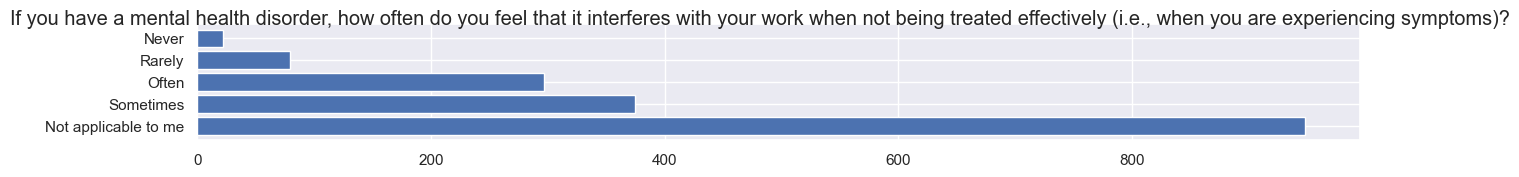

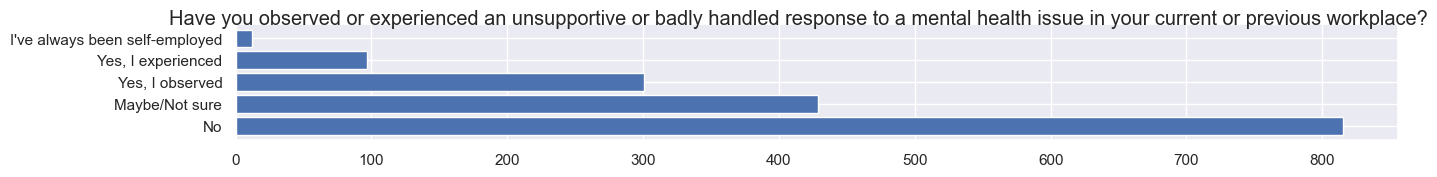

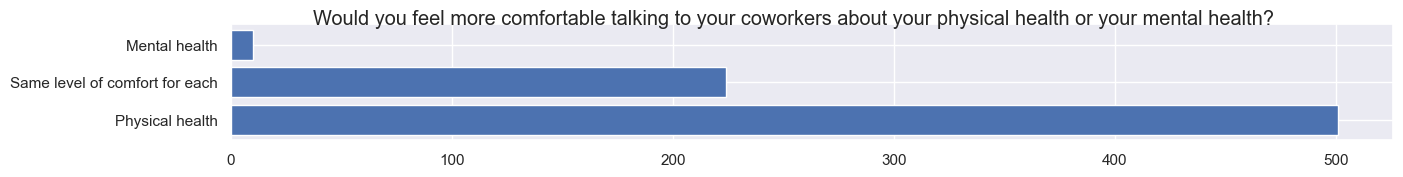

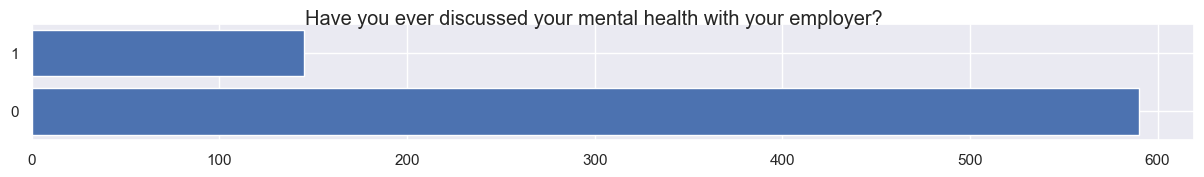

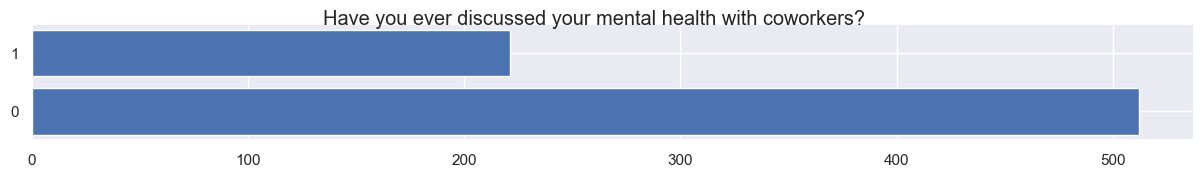

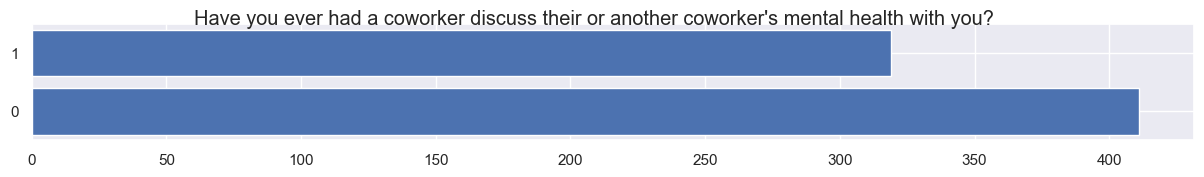

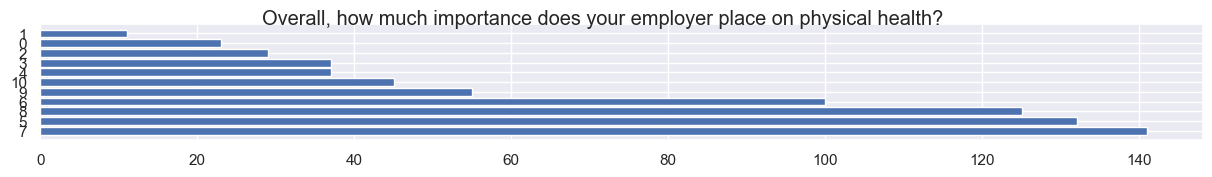

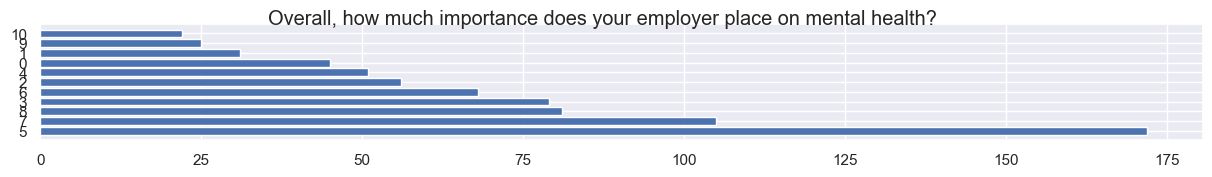

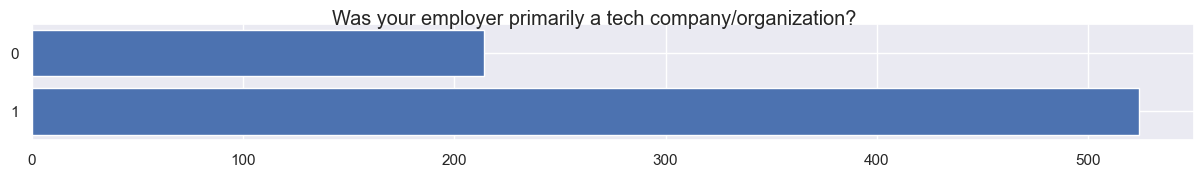

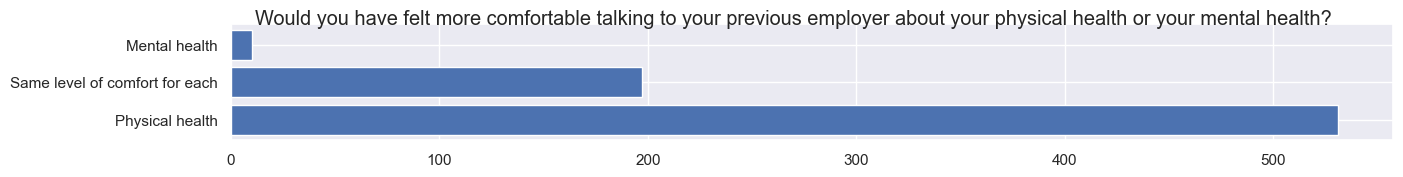

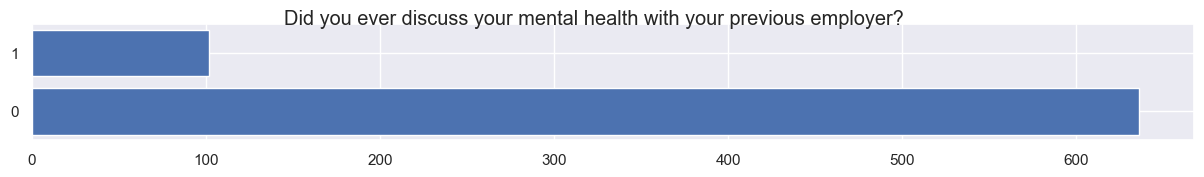

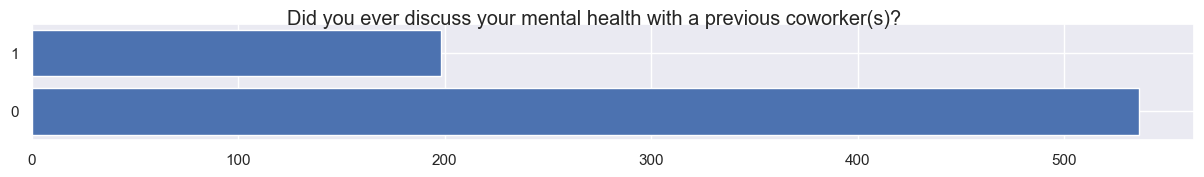

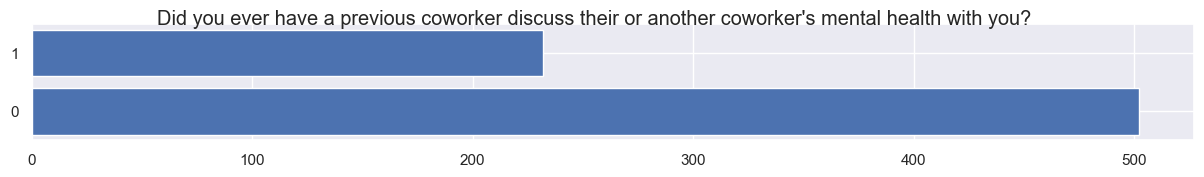

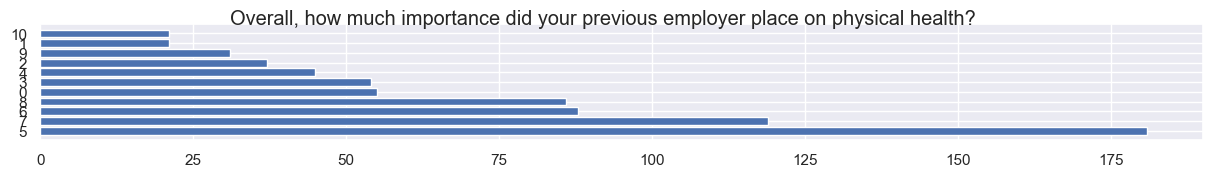

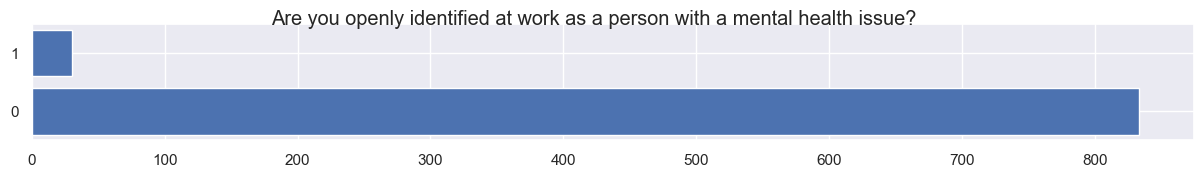

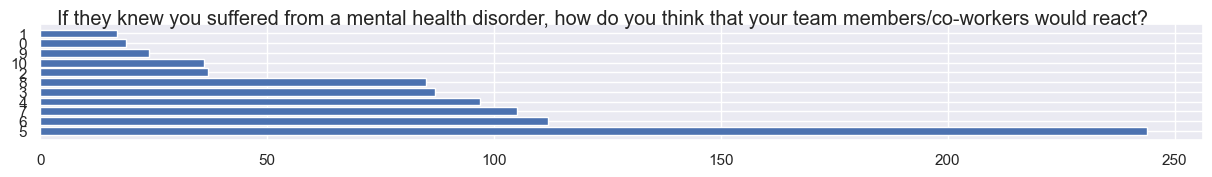

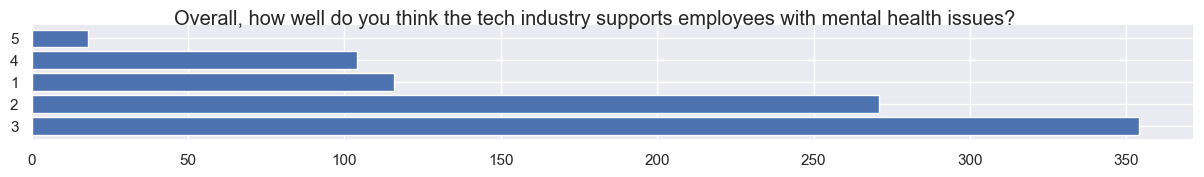

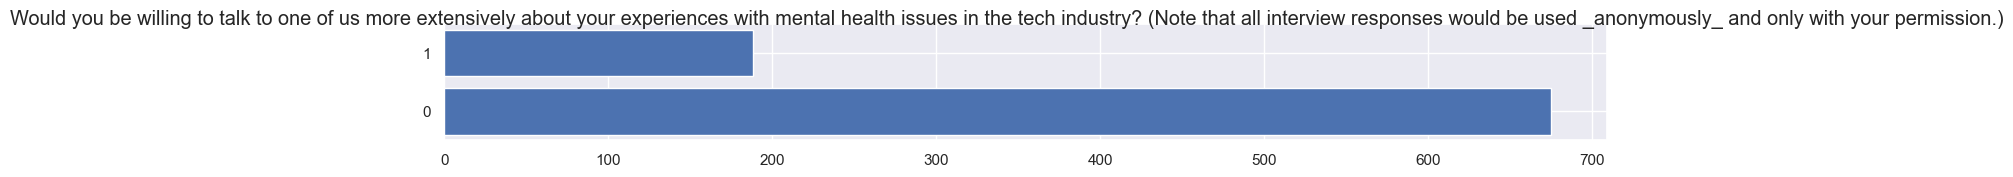

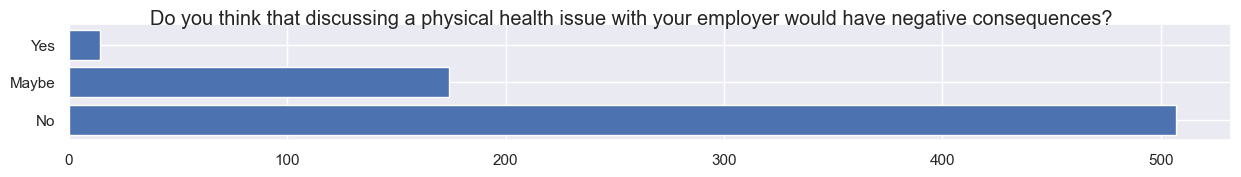

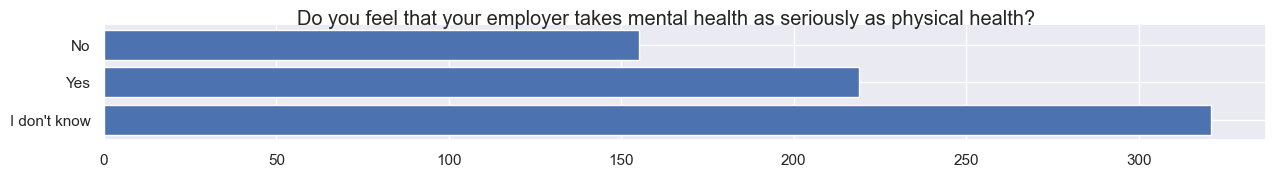

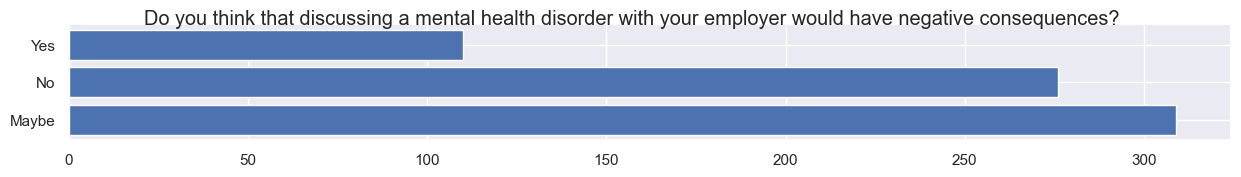

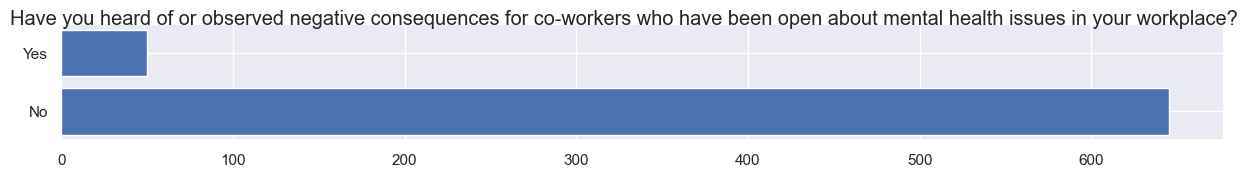

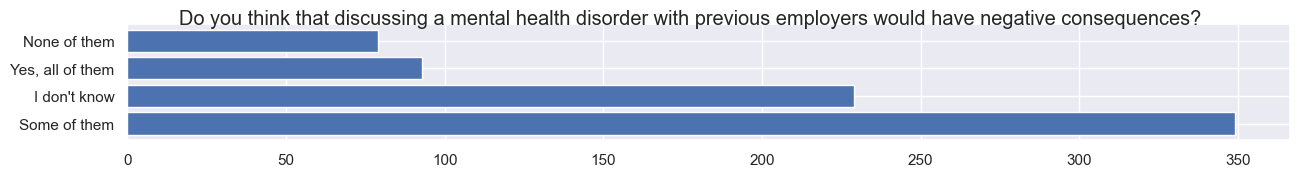

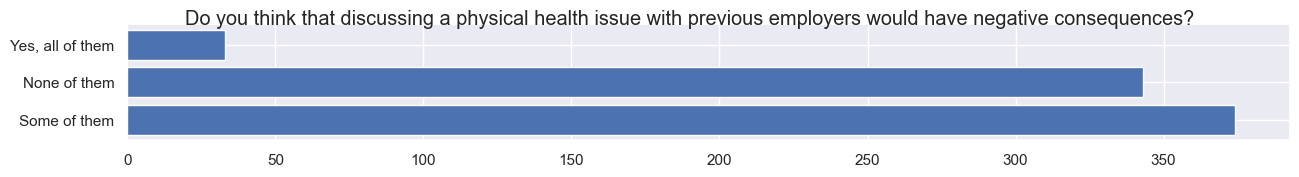

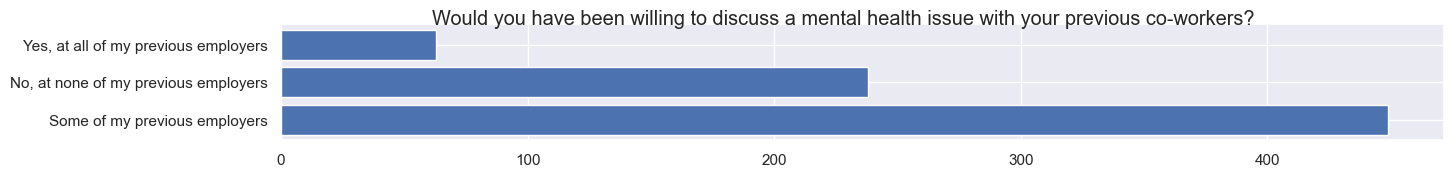

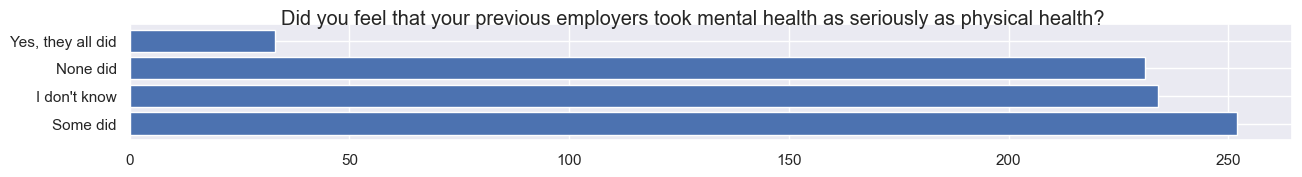

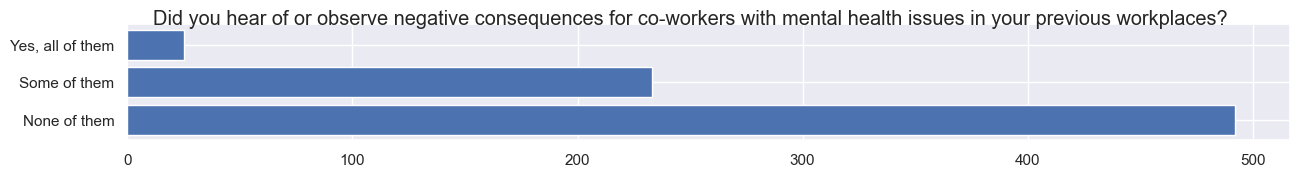

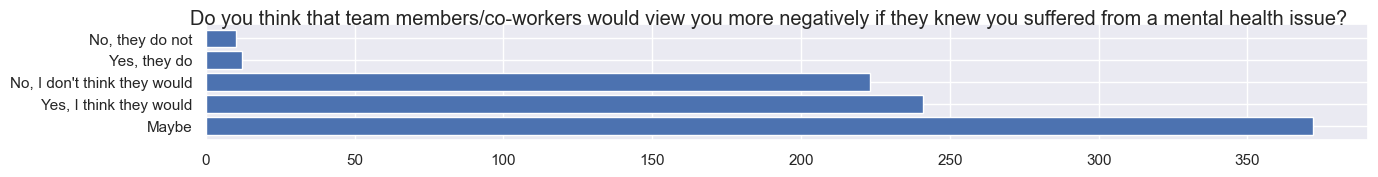

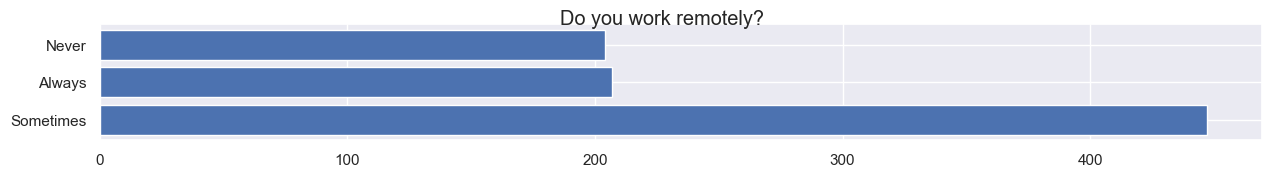

In [54]:
category_filtered = null_filtered[questions_to_keep]
## Check the responses to each question ##
for col_name, col_data in category_filtered.items():
    ## See how many unique responses there are to each question ##
    qtxt = pd.read_sql_query(f'SELECT QuestionText FROM Question WHERE questionid = {col_name}', con).values[0][0]
    plt.figure(figsize=(15,1.5))
    plt.barh(col_data.explode().value_counts().index, col_data.explode().value_counts().values)
    plt.suptitle(f'{qtxt}')
    
    for value in col_data.dropna():
        if len(value) > 1: # Check that there are only singular responses to each question
            print(f'Question {col_name} has a respondant that provided {len(value)} answers')

**What are the main themes in the remaining questions?**

In [55]:
## Convert the list of strings back into a string ##
data_to_clean = category_filtered.apply(lambda col: col.explode())
questions_data_available = pd.read_sql_query(f'SELECT QuestionText FROM Question WHERE questionid IN {tuple(list(data_to_clean.columns))}', con)

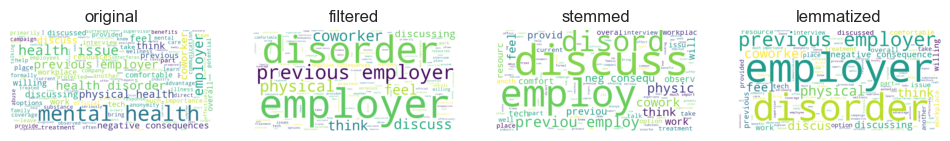

In [56]:
mh.create_word_cloud(questions_data_available)

- The most common theme in the remaining questions seem to relate to the word 'employer', so perhaps filter the features to only questions about employer treatment/workplace environment

**Manually select work environment related questions, and see if they differ between those that have sought out treatment versus those that haven't (i.e. the target variable)**

In [64]:
workenv_questions = [7,8,9,10,11,12,14,15,16,17,18,19,23,24,25,26,27,28,29,48,49,56]
target_question = 7
workenv_df = data_to_clean[[x for x in data_to_clean.columns if x in workenv_questions]]

## Drop any rows with null values for any of the feautres ##
workenv_df = workenv_df.dropna()

X = workenv_df.drop(target_question, axis=1)
y = workenv_df[[target_question]].astype(int)

C:\Users\61407\AppData\Local\Temp\ipykernel_24788\2176679508.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(8, 3))


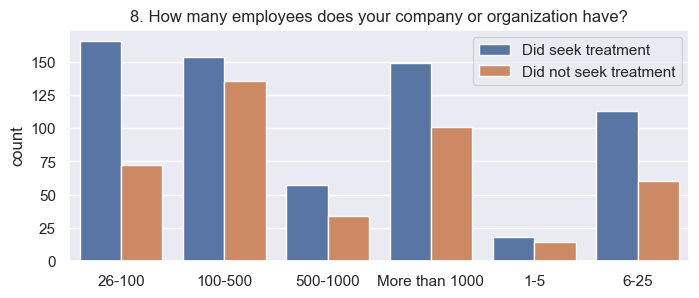

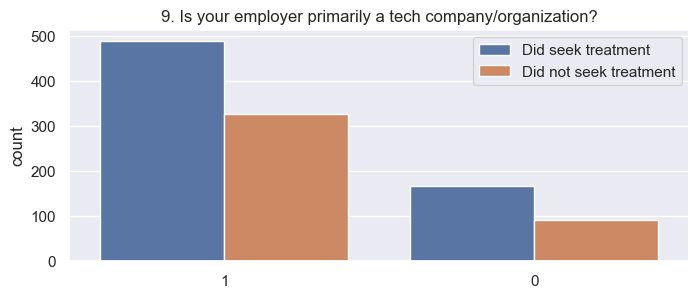

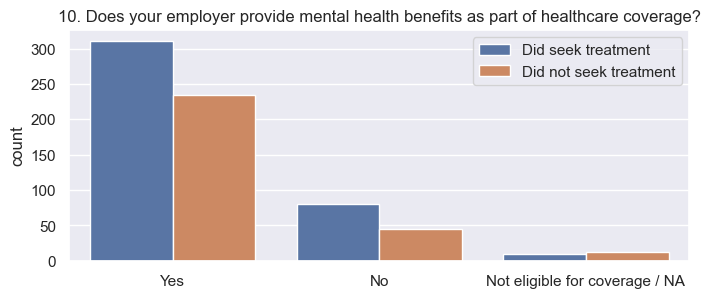

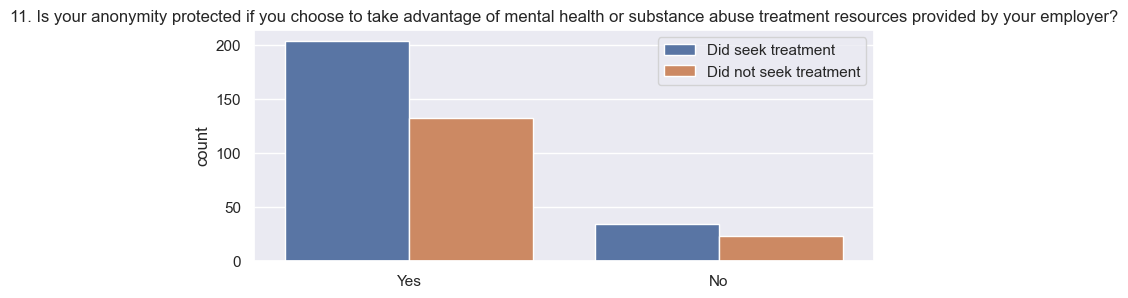

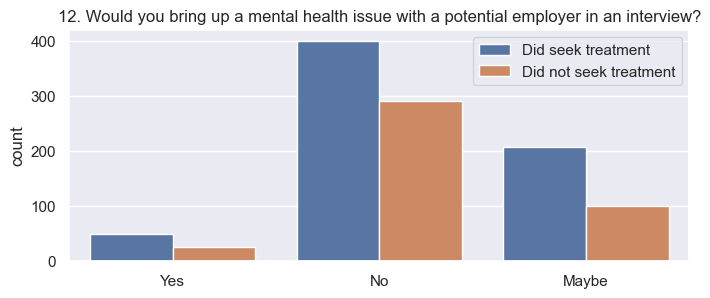

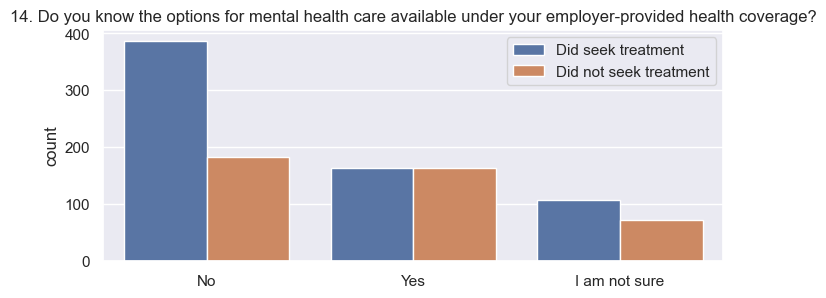

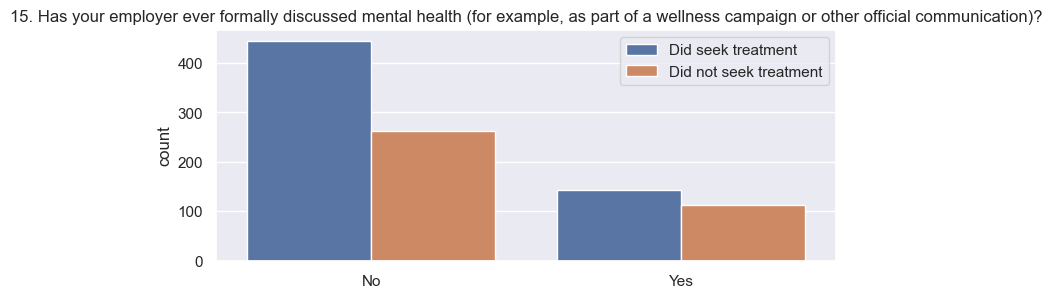

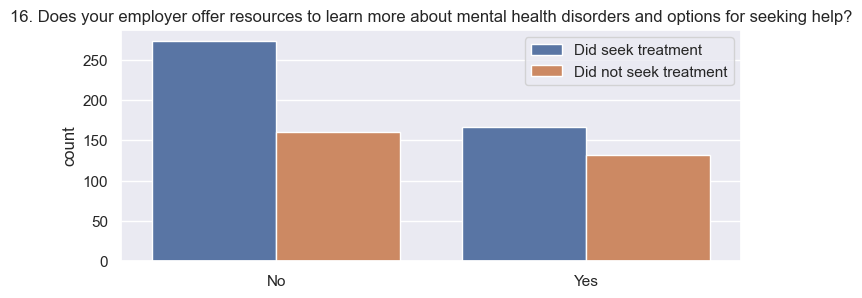

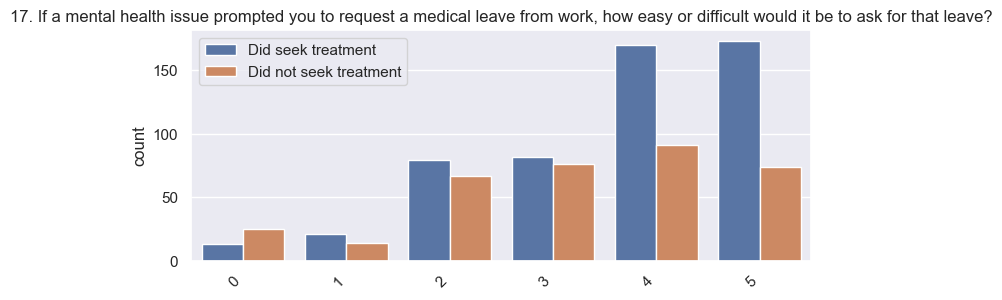

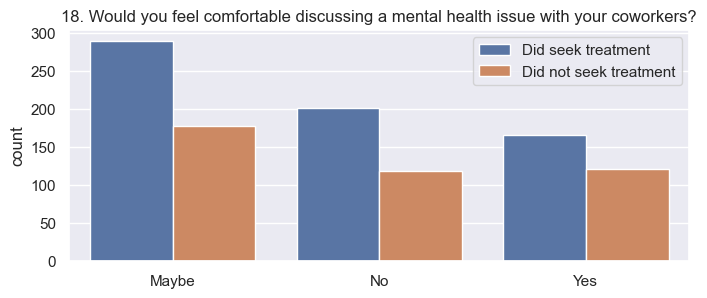

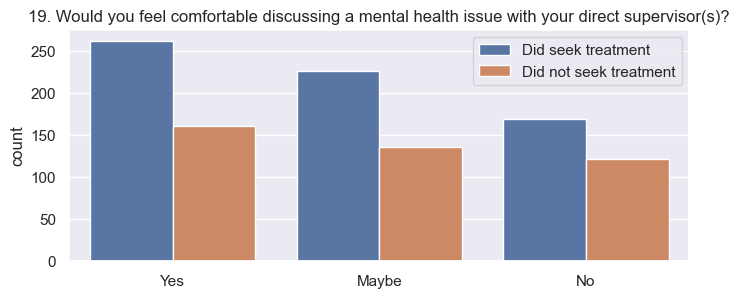

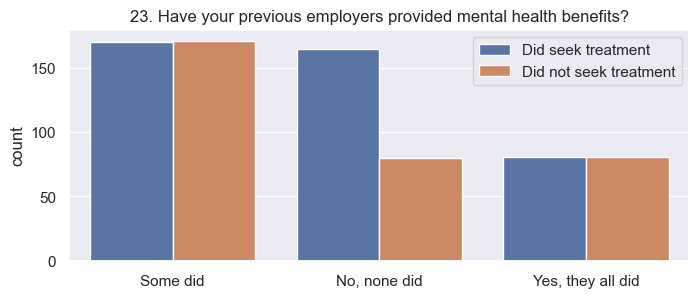

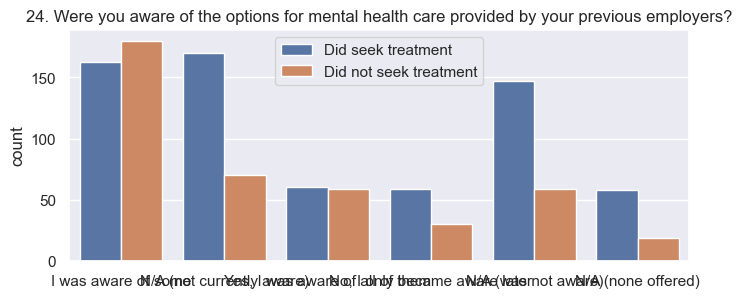

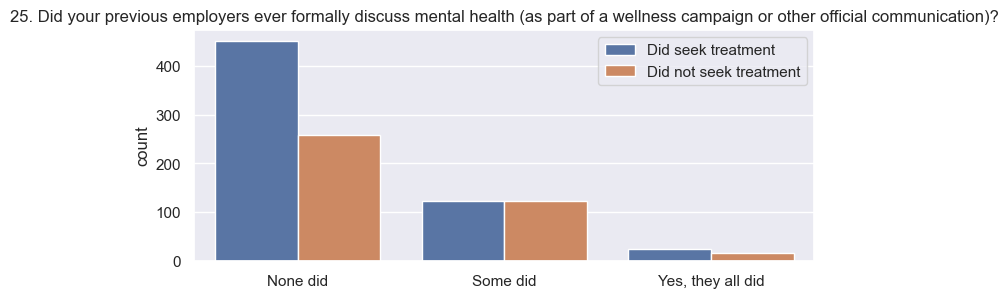

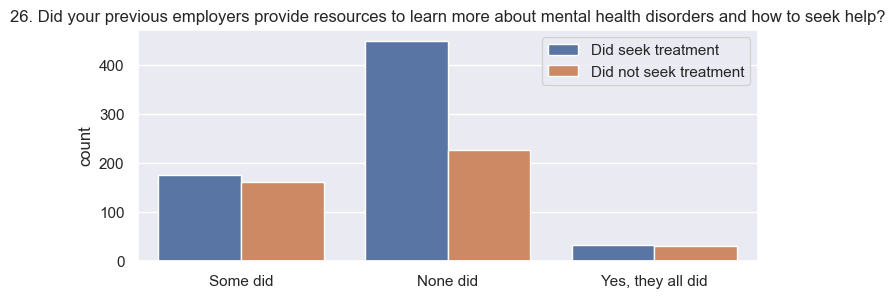

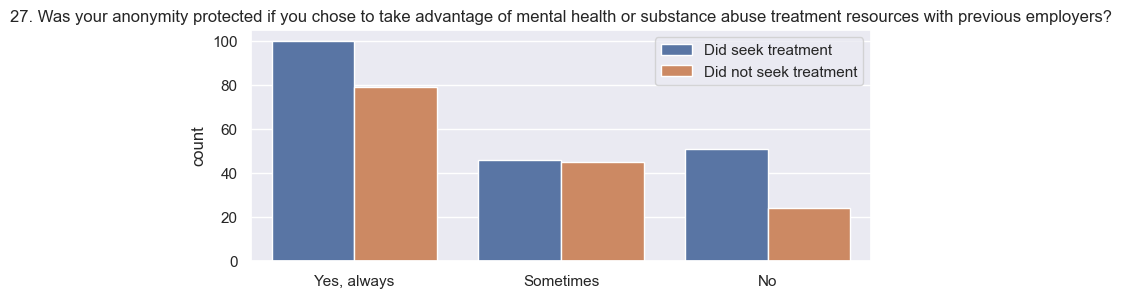

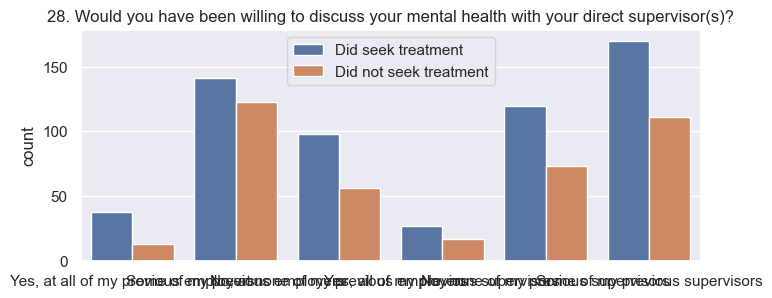

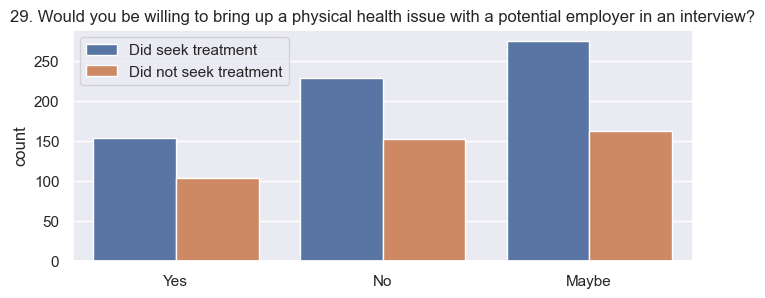

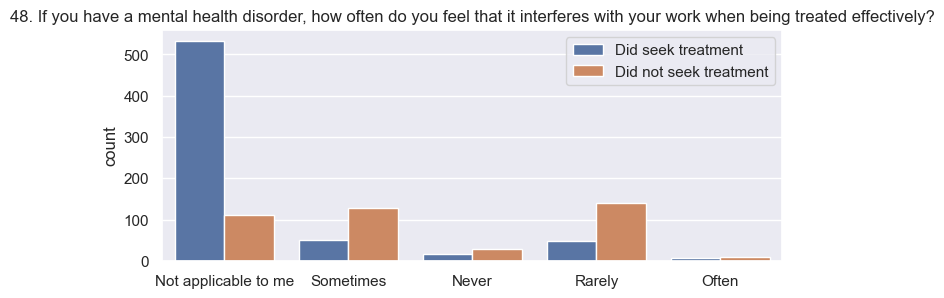

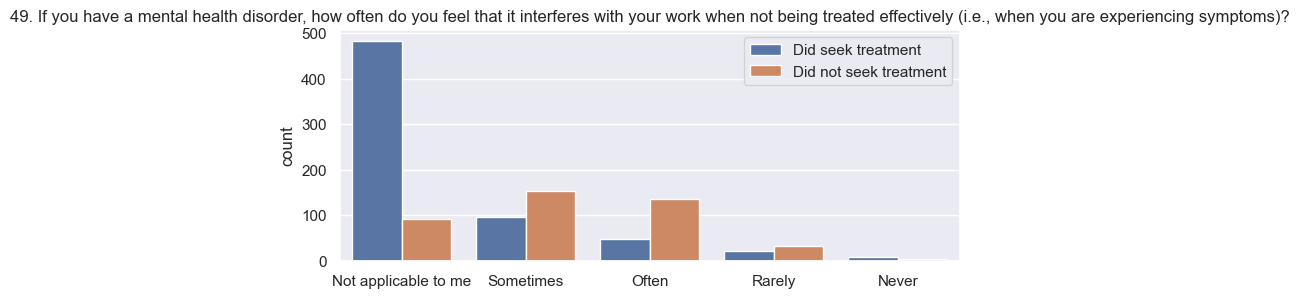

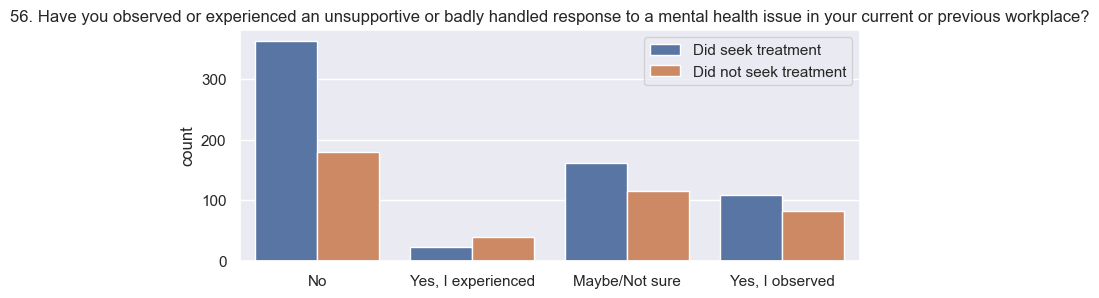

In [119]:
for feature in workenv_df.columns:
    if feature != target_question:
        fig = plt.figure(figsize=(8, 3))
        data = workenv_df[[feature, target_question]]
        data = data[data[feature] != "I don't know"]
        if feature == 17:
            sns.countplot(data, x=data[feature], hue=data[target_question], order=['Very difficult','Difficult','Somewhat difficult','Neither easy nor difficult','Somewhat easy','Very easy'])
        else:
            sns.countplot(data, x=data[feature], hue=data[target_question])
        plt.legend(['Did seek treatment','Did not seek treatment'])
        plt.xlabel('')
        plt.title(str(feature)+'. '+pd.read_sql_query(f'SELECT QuestionText FROM Question WHERE questionid = {feature}', con)['questiontext'][0])
        
        if feature == 17:
            plt.xticks([0,1,2,3,4,5], ['0','1','2','3','4','5'], rotation=45, ha='right')
            fig.savefig(f'q{feature}_countplot_ordinal.svg')

- Do a final check to see if there are any class imbalances in the target variable after treating null-values/feature selection

38.800000000000004% of people have sought out treatment


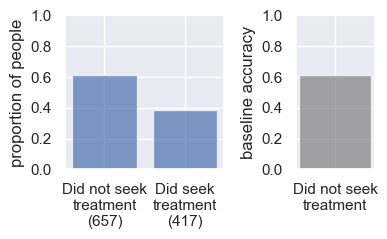

In [134]:
## Plot histogram ##
fig, ax = plt.subplots(nrows=1, ncols=2,
                       figsize=(4,2),
                       gridspec_kw={'width_ratios':[2,1],
                                    'wspace':0.6})

## Set axes ##
counts = y.value_counts()
prop_treat = round((counts[1] / (counts[0]+counts[1])),3)
print(f'{prop_treat*100}% of people have sought out treatment')
ax[0].bar([0,1], [1-prop_treat, prop_treat], alpha=0.7)
ax[0].set_xticks([0,1])
ax[0].set_xticklabels([f'{label}\n({count})' for label,count in zip(['Did not seek\ntreatment','Did seek\ntreatment'], counts)])
ax[0].set_ylim(0,1)
ax[0].set_ylabel('proportion of people')

ax[1].bar(0, 1-prop_treat, color='grey', alpha=0.7)
ax[1].set_ylabel("baseline accuracy")
ax[1].set_xticks([0])
ax[1].set_xticklabels(['Did not seek\ntreatment'])
ax[1].set_ylim(0,1);
fig.savefig('target_distribution.svg')

# Data Cleaning/Pre-processing #

**Which questions/features could be obviously encoded in an ordinal way?**
- For quality of work environment-related features, we will consider "more positive" responses as higher numbers

In [93]:
ordinal_features = [8,17,23,25,26,27,28,29,48,49,56]

## 8. How many employees does your company or organization have? ##
order8 = {'1-5':0, '6-25':1, '26-100':2, '100-500':3, '500-1000':4, 'More than 1000':5}

## 17. If a mental health issue prompted you to request a medical leave from work, how easy or difficult would it be to ask for that leave? ##
order17 = {'Very difficult':0, 'Difficult':1, 'Somewhat difficult':2, 'Neither easy nor difficult':3, "I don't know":4, 'Somewhat easy':5, 'Easy':6, 'Very easy':7}

## 23. Have your previous employers provided mental health benefits? ##
order23 = {'No, none did':0, 'Some did':1, "I don't know": 2, 'Some did':3, 'Yes, they all did':4}

## 25. Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)? ##
order25 = {'None did':0, 'Some did':1, "I don't know":2, 'Yes, they all did':3}

## 26. Did your previous employers provide resources to learn more about mental health disorders and how to seek help? ##
order26 = {'None did':0, 'Some did':1, 'Yes, they all did':2}

## 27. Was your anonymity protected if you chose to take advantage of mental health or substance abuse treatment resources with previous employers? ##
order27 = {'No':0, 'Sometimes':1, "I don't know":2, 'Yes, always':3}

## 28. Would you have been willing to discuss your mental health with your direct supervisor(s)? ##
order28 = {'No, at none of my previous employers':0, 'No, none of my previous supervisors':1, 'Some of my previous employers':2, 'Some of my previous supervisors':3, "I don't know":4, 'Yes, at all of my previous employers':5, 'Yes, all of my previous supervisors':6}

## 29. Would you be willing to bring up a physical health issue with a potential employer in an interview? ##
order29 = {'No':0, 'Maybe':1, 'Yes':2}

## 48. If you have a mental health disorder, how often do you feel that it interferes with your work when being treated effectively? ##
order48 = {'Often':0, 'Sometimes':1, 'Rarely':2, 'Never':3, 'Not applicable to me':4}

## 49. If you have a mental health disorder, how often do you feel that it interferes with your work when not being treated effectively (i.e., when you are experiencing symptoms)? ##
order49 = {'Often':0, 'Sometimes':1, 'Rarely':2, 'Never':3, 'Not applicable to me':4}

## 56. Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace? ##
order56 = {'Yes, I experienced':0, 'Yes, I observed':1, 'Maybe/Not sure':2, 'No':3}

ordinal_dict = {8:order8, 17:order17, 23:order23, 25:order25, 26:order26, 27:order27, 28:order28, 29:order29, 48:order48, 49:order49, 56:order56}

- Encode the ordinal variables manually

In [78]:
ordinal_encoded = []
for f, order in ordinal_dict.items():
    df = workenv_df[[f]]
    df[f] = df[f].replace(order)
    ordinal_encoded.append(df)
ordinal_encoded = pd.concat(ordinal_encoded, axis=1)
ordinal_encoded.columns = [str(x) for x in ordinal_encoded.columns]

C:\Users\61407\AppData\Local\Temp\ipykernel_24788\349715742.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f] = df[f].replace(order)
C:\Users\61407\AppData\Local\Temp\ipykernel_24788\349715742.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f] = df[f].replace(order)
C:\Users\61407\AppData\Local\Temp\ipykernel_24788\349715742.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

- Encode nominal features

In [79]:
from sklearn.preprocessing import OneHotEncoder

nominal_features = [x for x in workenv_df.columns if (x not in ordinal_features) & (x != target_question)]
nominal_df = workenv_df[nominal_features]

encoder = OneHotEncoder(sparse=False, handle_unknown='error')
encoder.fit(nominal_df)

encoded_names = []
for q, alist in zip(nominal_features, encoder.categories_):
    for a in alist:
        encoded_names.append(str(q)+'_'+('_').join(a.split(' ')))
        
nominal_encoded = pd.DataFrame(encoder.transform(nominal_df),
                         columns = encoded_names,
                         index = nominal_df.index)

C:\Users\61407\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


- combine ordinal and nominal encoded feature matrix

In [80]:
X_encoded = pd.concat([ordinal_encoded, nominal_encoded], axis=1)

**Do some standardizing of input features**
- Since we have a mixture of binary (i.e. one-hot encoded) and ordinal features, we will use a min-max normalization instead of a z-scoring. This will preserve the binary nature of the one-hot encoded features, whilst transforming all of the ordinal features to range between 0 and 1 as well.

In [90]:
X_scaled = (X_encoded - X_encoded.min()) / (X_encoded.max() - X_encoded.min())

- save the cleaned data

In [92]:
cleaned_data = {'X_scaled':X_scaled, 'y':y}
np.save('cleaned_data_q1.npy', cleaned_data, allow_pickle=True)